In [136]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split

In [137]:
#import data

#Go here for the data: https://www.kaggle.com/ntnu-testimon/paysim1

df = pd.read_csv("/Users/chrisjackson/AML Detect/PS_20174392719_1491204439457_log.csv")


# Explore Data

### Dataset description

1.  step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2.  type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3.  amount - amount of the transaction in local currency.
4.  nameOrig - customer who started the transaction
5.  oldbalanceOrg - initial balance before the transaction
6.  newbalanceOrig - new balance after the transaction
7.  nameDest - customer who is the recipient of the transaction
8.  oldbalanceDest - initial balance recipient before the transaction. Note that there is no information for customers that start with M (Merchants).
9.  newbalanceDest - new balance recipient after the transaction. Note that there is no information for customers that start with M (Merchants).
10.  isFraud - These are transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. Will use this as the target.
11.  isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [138]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [139]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [140]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [141]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [142]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [143]:
df.loc[df['isFraud'] == 1].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,8213.00,8213.00,8213.00,8213.00,8213.00,8213.00,8213.00,8213.00
mean,368.41,1467967.30,1649667.61,192392.63,544249.62,1279707.62,1.00,0.00
std,216.39,2404252.95,3547719.44,1965666.46,3336420.95,3908816.53,0.00,0.04
min,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,181.00,127091.33,125822.44,0.00,0.00,0.00,1.00,0.00
50%,367.00,441423.44,438983.45,0.00,0.00,4676.42,1.00,0.00
75%,558.00,1517771.48,1517771.48,0.00,147828.66,1058725.22,1.00,0.00
max,743.00,10000000.00,59585040.37,49585040.37,236230516.82,236726494.66,1.00,1.00


# Feature Engineering 

Making new columns from existing data

In [144]:
# create column that shows whether the transcation plus the amount is equal to the new balance 

df['accountedFor'] = np.where((df['oldbalanceDest'] + df['amount'] >= df['newbalanceDest'] - 200) & 
                              (df['oldbalanceDest'] + df['amount'] <= df['newbalanceDest']), 1, 0)

In [145]:
df['accountedFor'].value_counts()

0    4281312
1    2081308
Name: accountedFor, dtype: int64

In [146]:
# create column that shows whether the transaction amount is greater than 10000, 1 yes, 0 no

df['largeTransaction'] = np.where((df['amount'] > 50000) , 1, 0)

In [147]:
df['largeTransaction'].value_counts()

1    3556673
0    2805947
Name: largeTransaction, dtype: int64

In [148]:
# create column that shows the number of times this person has received money

df['freqReceiver'] = df.groupby('nameDest')['nameDest'].transform('count')

In [149]:
df['freqReceiver'].value_counts()

1     2262704
5      184105
6      182496
7      180649
4      180460
       ...   
91         91
88         88
85         85
83         83
78         78
Name: freqReceiver, Length: 101, dtype: int64

In [150]:
# create column that shows if this person is a merchant or not, 1 yes, 0 no

df['merchant'] = np.where((df['nameDest'].str.contains('M')) , 1, 0)

In [151]:
df['merchant'].value_counts()

0    4211125
1    2151495
Name: merchant, dtype: int64

In [152]:
# import graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()

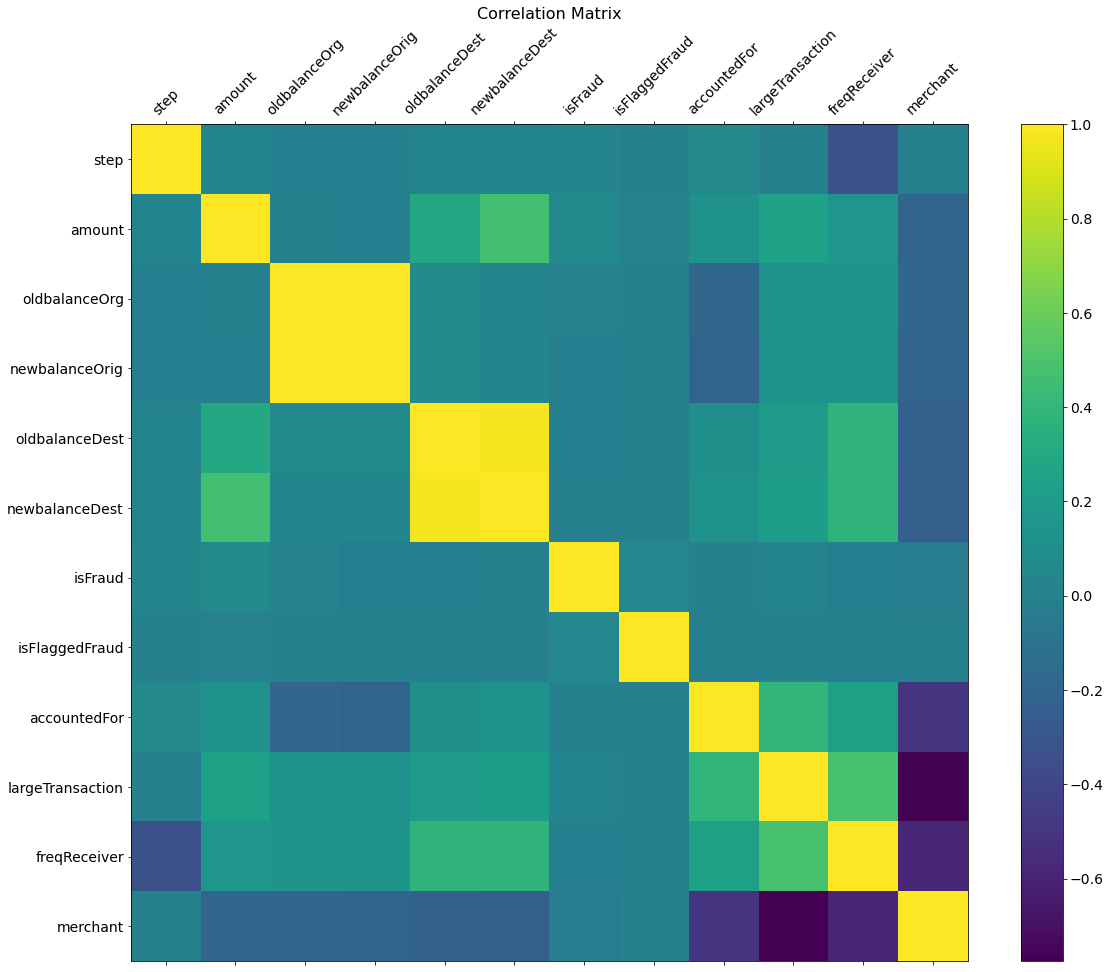

In [153]:
# show correlation between variables

f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

huge imbalance here so need to fix that by either oversampling minority or undersampling the majority

In [115]:
# Making the dataset smaller

SmallDF = df.sample(frac=0.1, random_state=1)

#Getting the max size
max_size = SmallDF['isFraud'].value_counts().max()

#Balancing the target label (Fraud) - I really dont like this method but it works for now, Would like to find a better way to do this with SMOTE or something similar
lst = [SmallDF]
for class_index, group in SmallDF.groupby('isFraud'):
    lst.append(group.sample(max_size-len(group), replace=True))
SmallDF = pd.concat(lst)


In [116]:
SmallDF['isFraud'].value_counts()

1    63751
0    63751
Name: isFraud, dtype: int64

In [101]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()

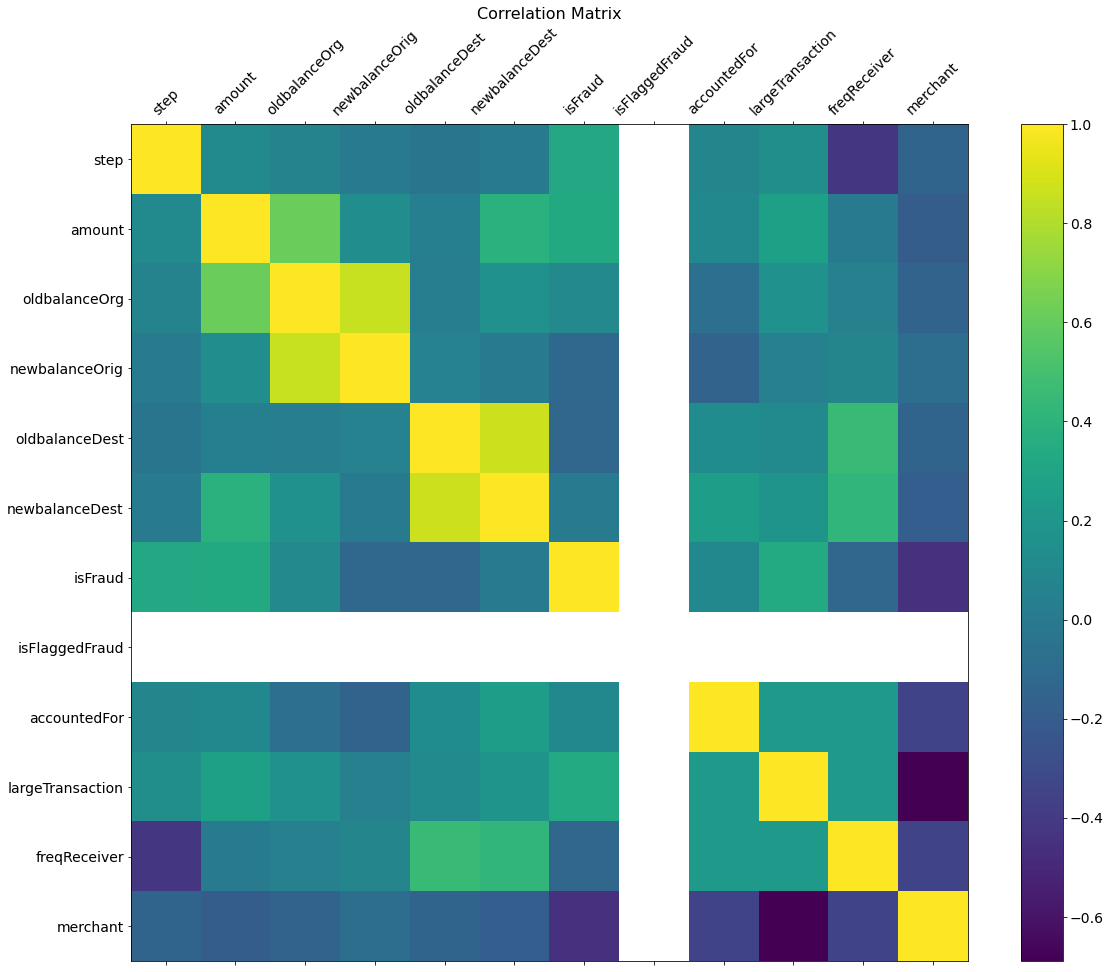

In [119]:
f = plt.figure(figsize=(19, 15))
plt.matshow(SmallDF.corr(), fignum=f.number)
plt.xticks(range(SmallDF.select_dtypes(['number']).shape[1]), SmallDF.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(SmallDF.select_dtypes(['number']).shape[1]), SmallDF.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

This is far from the most efficeint method as it nearly doubles the total transactions by oversampling the fraudulent ones.

# Modelling

In [102]:
X = SmallDF.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = SmallDF['isFraud']

In [103]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1270886 entries, 6322570 to 1030495
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              1270886 non-null  int64  
 1   type              1270886 non-null  object 
 2   amount            1270886 non-null  float64
 3   oldbalanceOrg     1270886 non-null  float64
 4   newbalanceOrig    1270886 non-null  float64
 5   oldbalanceDest    1270886 non-null  float64
 6   newbalanceDest    1270886 non-null  float64
 7   accountedFor      1270886 non-null  int64  
 8   largeTransaction  1270886 non-null  int64  
 9   freqReceiver      1270886 non-null  int64  
 10  merchant          1270886 non-null  int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 116.4+ MB


In [104]:
# set up pipeline for imputation and scaling of categorical variables and numerical variables
num_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
cat_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [105]:
# get column indexes for categorical and numerical variables
num_features = X.select_dtypes(include=['int64', 'float64'])
cat_features = X.select_dtypes(include=['object'])

numeric_cols = X.dtypes.apply(lambda x: x.kind in 'bifc').reset_index(
    drop=True).loc[lambda x: x == True].index
cat_cols = (X.dtypes == 'object').reset_index(
    drop=True).loc[lambda x: x == True].index

In [106]:
# set up column transformer for categorical and numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transform,  selector(dtype_exclude="object")),
        ('cat', cat_transform, selector(dtype_include="object"))])

In [107]:
# use pipeline to impute and scale numerical variables and one hot encode categorical variables
X_pipe = preprocessor.fit_transform(X)

# split data into train and test sets and make the size of samlpe smaller for faster processing
X_train, X_test, y_train, y_test = train_test_split(
    X_pipe, y, train_size=0.025, test_size=0.005, random_state=42, stratify=y)

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [72]:
# Initiaze the hyperparameters for LR model

paramLR = {'penalty': ['l1', 'l2'],
           'C': [0.1, 0.5, 1, 10, 50, 100],
           'solver': ['newton-cg', 'lbfgs', 'newton-cholesky', 'sag', 'saga'],
           'class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]}

In [63]:
# set up the various models for classification
models = [
    {'model': LogisticRegression(random_state=42), 'param': paramLR}
]

In [70]:
# function to loop through models and hyperparameters and return results

def run_models(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

      results = []
      target_names = ['no fraud', 'fraud']
      for model in models:
            print(" Results from Grid Search ", model['model'])
            gridSearch = GridSearchCV(model['model'], model['param'], cv=5, scoring='f1_micro', verbose = 1, n_jobs=-1)
            gridSearch.fit(X_train, y_train)
            print("\n The best estimator across ALL searched params:\n", gridSearch.best_estimator_)
            print("\n The best score across ALL searched params:\n", gridSearch.best_score_)
            print("\n The best parameters across ALL searched params:\n", gridSearch.best_params_)
            predic = gridSearch.predict(X_test)
            print(classification_report(y_test, predic))
            results.append({'name': model['model'], 'best_estimator': gridSearch.best_estimator_,'report': classification_report(y_test, predic, target_names=target_names, output_dict=True)})
      return results

In [ ]:
results = run_models(X_train, y_train, X_test, y_test)

# Run best paramaters from above in the model on a seperate test set

In [154]:
# Set up the best model from above
LR = LogisticRegression(C=100, class_weight=None, penalty='l2', solver='lbfgs', random_state=42, max_iter=1000)

# Reduce the size of the data set to 10% of the original size for faster processing
df.sample(frac=0.1, random_state=1)
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

# use pipeline to impute and scale numerical variables and one hot encode categorical variables
X_pipe = preprocessor.fit_transform(X)

# split data into train and test sets and make the size of samlpe smaller for faster processing
X_train, X_test, y_train, y_test = train_test_split(
    X_pipe, y, train_size=0.1, test_size=0.05, random_state=42, stratify=y)

LR.fit(X_train, y_train)
predictions = LR.predict(X_test)

In [155]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    317720
           1       0.90      0.53      0.67       411

    accuracy                           1.00    318131
   macro avg       0.95      0.77      0.83    318131
weighted avg       1.00      1.00      1.00    318131



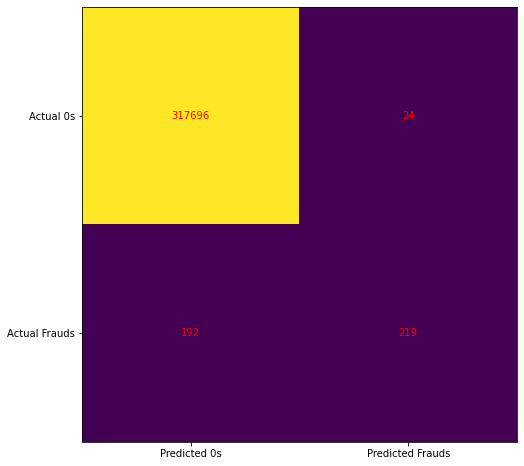

In [158]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted Frauds'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual Frauds'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

This basic model caught roughly half the Frauds (219) out of a total Frauds of 435